<a href="https://colab.research.google.com/github/vedrocks15/Quantum-Convolutional-Layers/blob/master/Quanvolutional_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try to see the variations in the performace gains offered by a random quantum circuit to extract features

In [ ]:
! pip install pennylane

In [ ]:
# qml used to register qubit as devices
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers # helps in the generation of a random circuit

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math

HyperParameters

In [ ]:
n_epochs = 30    # Number of optimization epochs
lr       = 0.05  # Learning rates
n_train  = 50    # no of images for training
n_test   = 10    # no of images for testing

Loading & pre-processing MNIST Data

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Select appropriate number of images
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Add extra dimension for convolution channels
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]


In [ ]:
print(len(train_images))
print(len(test_images))

50
10


# Building of a custom Quantum Convolutional Layer

The experiment does not modify the paramters of the quantum circuit

In [ ]:
class Quanvolutional_Layer(keras.layers.Layer):

  def __init__(self,size_filter,layers_filter,stride_filter,padding):
    super(Quanvolutional_Layer,self).__init__()
    self.size_filter   = size_filter
    self.layers_filter = layers_filter
    self.stride_filter = stride_filter
    self.padding       = padding
    # Based on the quanvolutional filter size we set up appropriate number of wires since each pixel gets assigned a qubit (the encoding we went with)
    self.dev           = qml.device("default.qubit", wires=(self.size_filter*self.size_filter))
    # Random parameters required for each quantum convolutional filter based on the number of wires i.e. filter size
    self.rand_params   = np.random.uniform(high=2 * np.pi, size=(layers_filter, (size_filter*size_filter)))
    print("Created Basic Properties")

  # The qfilter generted will have the following gate properties :
  # 1) Encoding  : Ry rotation gate where the angles are scaled by PI
  # 2) Ciruit    : Of n_layers random in nature
  # 3) Decoding  : 4 expectation value measurements
  # decorator for quantum node

  def creator(self,phi):
    print(phi)

    @qml.qnode(self.dev,interface="tf")
    def circuit(self,phi):
      print("Reached inside")
      # Encoding on each of the filter value along each wire
      for j in range(self.size_filter*self.size_filter):
        qml.RY(np.pi * phi[j].numpy(), wires=j)
      # Random quantum circuit generation based on the random paramters we chose
      RandomLayers(self.rand_params, wires=list(range(self.size_filter*self.size_filter)))
      #Measurement producing 4 classical output values, each of this value is plugged along a channel
      return [qml.expval(qml.PauliZ(j)) for j in range(self.size_filter*self.size_filter)]
    
    return circuit(self,phi)

  def call(self,image):
    # 2x2 filter with stride 1 and passes the data through the quantum circuit
    # the output of the qunatum ciruit is 4 that is mapped into 4 different channels indicating the same pixel
    calc = math.floor((image.shape[1]+2*self.padding-self.size_filter)/self.stride_filter) + 1
    out = np.zeros((calc,calc,(self.size_filter*self.size_filter)))
    print(image.shape)
    print(out.shape)
    
    # steps of stride
    index = 0 
    for i in image:
      for j in range(0, i.shape[0], self.stride_filter):
        for k in range(0, i.shape[1], self.stride_filter):
          print("Looper")
          # The cicuit remains the same because the uniform random sampling is done only once
          q_results = self.creator([i[j, k, 0], i[j, k + 1, 0], i[j + 1, k, 0], i[j + 1, k + 1, 0]])
          print(q_results)
          # appropriate expectation value is assigned to right channel
          for c in range((self.size_filter*self.size_filter)):
            out[j // 2, k // 2, c] = q_results[c]
      index+=1
    return out


In [ ]:
class Quanvolutional_Layer():

  def __init__(self,size_filter,layers_filter,stride_filter,padding):
    self.size_filter   = size_filter         # Determines the number of qubits to be required for the random cicuit (2-4)[time increases NP hard]
    self.layers_filter = layers_filter       # Number of random circuits since each filter is a realization of a circuit
    self.stride_filter = stride_filter       # Stride same meaning as classical counterpart
    self.padding       = padding             # Experimental feature ***Not Implemented***

    # Circuit design i.e. number of qubits required for encoding
    self.dev           = qml.device("default.qubit", wires=self.size_filter*self.size_filter)

    # Along each circuit we require (filter_size)^2 parameters randomly initialized
    self.rand_params   = np.random.uniform(high=2 * np.pi, size=(self.layers_filter, (self.size_filter*self.size_filter)))
    print("Created Basic Properties")


  # The qfilter generted will have the following gate properties :
  # 1) Encoding  : Ry rotation gate where the angles are scaled by PI
  # 2) Ciruit    : Of n_layers random in nature
  # 3) Decoding  : 4 expectation value measurements
  # decorator for quantum node
  def creator(self,phi):
    # Due the decorator access we specified a function inside another function

    @qml.qnode(self.dev)
    def circuit(phi):
      # List containg all qubit outputs
      op_list = []

      # Encoding on each of the filter value along each wire
      for j in range(self.size_filter*self.size_filter):
        qml.RY(np.pi * phi[j], wires=j) # BloC sphere mapping

      # Random quantum circuit generation based on the random paramters we chose
      # The first dimension of rand_params (adjusts the number of layers we care about they are weights)
      # Iterating one filter at a time
      for k in self.rand_params:
        tmp = np.expand_dims(k,axis=0) # convert into 1 layer, number of qubits
        RandomLayers(tmp, wires=list(range(self.size_filter*self.size_filter)))
        for j in range(self.size_filter*self.size_filter):
          op_list.append(qml.expval(qml.PauliZ(j)))
      return op_list

    # op_list of shape : number of filters, number of qubits
    op_list = circuit(phi)
    op_list = np.array(op_list)
    return list(np.reshape(op_list, (self.layers_filter, (self.size_filter*self.size_filter))))

  def call(self,image):

    # Sanity check wether the paramters specified is alright for the image dimensions
    calc = math.floor((image.shape[1]+2*self.padding-self.size_filter)/self.stride_filter) + 1
    if calc <1:
      return -1
    # Stide reductions along the height and width dim & filter size = number of filters * number of qubits
    out = np.zeros((calc,calc,self.layers_filter*(self.size_filter*self.size_filter)))
    print(image.shape)
    print(out.shape)
    

    # Output collection array
    collection = []
    index = 0
    for i in image:
      out = np.zeros((calc,calc,self.layers_filter*(self.size_filter*self.size_filter)))
      # Progress checker
      print("Image processed :",index+1)
      # Stride based steps
      for j in range(0, i.shape[0], self.stride_filter):
        for k in range(0, i.shape[1], self.stride_filter):
          phi = []
          # Padding not yet implemented
          if(j+self.size_filter > i.shape[0]) | (k+self.size_filter > i.shape[1]):
            continue
          for l in range(j,j+self.size_filter): 
            for m in range(k,k+self.size_filter):
              phi.append(i[l][m][0])
              
          q_results = self.creator(phi)
          
          ctr = 0
          for x in q_results:
            for y in range(len(x)):
              out[j//self.stride_filter, k//self.stride_filter,ctr] = x[y]
              ctr+=1
      collection.append(out) 
      index+=1
    return collection


In [ ]:
Quan2D = Quanvolutional_Layer(2,1,2,0)
op_train = Quan2D.call(train_images)
op_train = np.asarray(op_train, dtype=np.float32)

op_test  = Quan2D.call(test_images)
op_test  = np.asarray(op_test, dtype=np.float32)
print(op_train.shape)
print(op_test.shape)
print(op_train[0])

Created Basic Properties
(50, 28, 28, 1)
(14, 14, 4)
Image processed : 1
Image processed : 2
Image processed : 3
Image processed : 4
Image processed : 5
Image processed : 6
Image processed : 7
Image processed : 8
Image processed : 9
Image processed : 10
Image processed : 11
Image processed : 12
Image processed : 13
Image processed : 14
Image processed : 15
Image processed : 16
Image processed : 17
Image processed : 18
Image processed : 19
Image processed : 20
Image processed : 21
Image processed : 22
Image processed : 23
Image processed : 24
Image processed : 25
Image processed : 26
Image processed : 27
Image processed : 28
Image processed : 29
Image processed : 30
Image processed : 31
Image processed : 32
Image processed : 33
Image processed : 34
Image processed : 35
Image processed : 36
Image processed : 37
Image processed : 38
Image processed : 39
Image processed : 40
Image processed : 41
Image processed : 42
Image processed : 43
Image processed : 44
Image processed : 45
Image proce

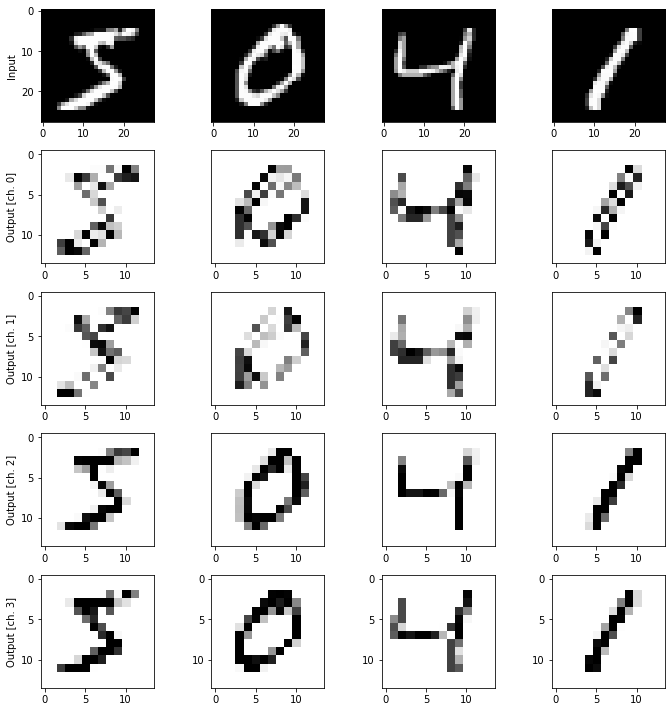

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(op_train[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Hybrid Model

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

In [ ]:
history = model.fit( op_train,
                     train_labels,
                     validation_data=(op_test, test_labels),
                     batch_size=4,
                     epochs=n_epochs,
                     verbose=2,)

Epoch 1/30
13/13 - 0s - loss: 7.3383 - accuracy: 0.1400 - val_loss: 32.1610 - val_accuracy: 0.0000e+00
Epoch 2/30
13/13 - 0s - loss: 10.7027 - accuracy: 0.1600 - val_loss: 2.9228 - val_accuracy: 0.5000
Epoch 3/30
13/13 - 0s - loss: 1.8496 - accuracy: 0.6000 - val_loss: 6.4975 - val_accuracy: 0.2000
Epoch 4/30
13/13 - 0s - loss: 2.8489 - accuracy: 0.5600 - val_loss: 1.2784 - val_accuracy: 0.6000
Epoch 5/30
13/13 - 0s - loss: 0.0946 - accuracy: 0.9600 - val_loss: 0.7793 - val_accuracy: 0.6000
Epoch 6/30
13/13 - 0s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.7533 - val_accuracy: 0.7000
Epoch 7/30
13/13 - 0s - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.7432 - val_accuracy: 0.7000
Epoch 8/30
13/13 - 0s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.6881 - val_accuracy: 0.7000
Epoch 9/30
13/13 - 0s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.7573 - val_accuracy: 0.7000
Epoch 10/30
13/13 - 0s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.7203 - val_accuracy: 0.8000
Epoch 11/30
1

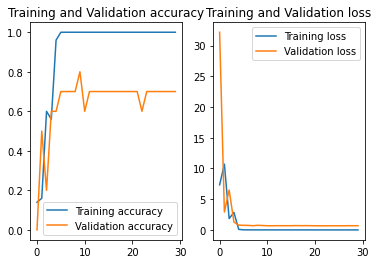

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()